## Part 1: Bellman Ford Algorithm

Implement Bellman-Ford Algorithm

In [1]:
import math

def bellman(veritices, edges, start, debug=False):
  # 1. Build graph
  # graph = {}
  # for u, v, w in edges:
  #   if u not in graph:
  #     graph[u] = { v: w}
  #   else:
  #     graph[u][v] = w

  # 2. Initialize distances
  distances = { vertix: float('inf') for vertix in veritices}
  distances[start] = 0

  # 3. Relax edges for n - 1 steps
  for i in range(len(veritices) - 1):
    if debug: print(f"{'*' * 10} iteration {i} {'*' * 10}")
    for u, v, w in edges:
      if distances[u] + w < distances[v]:
        distances[v] = distances[u] + w
      if debug:
        print(u, v)
        print(f"total={w + distances[u]}")
        print(distances)
  # print(distances)

  # 4. Detect negative cycle
  cycle = []
  for i in range(len(veritices) - 1):
    if debug: print(f"{'*' * 10} iteration {i} {'*' * 10}")
    for u, v, w in edges:
      if distances[u] + w < distances[v]:
        distances[v] = float('-inf')
        cycle.append(v)
  # print(distances)
  # print(cycle)
  return distances
  

# vertices=[1,2,3,4,5,6,7], edges=[(u, v, weight),...], start=1, expected={1:0, 2: 1, ... 7: 3} 
tests = [
  (
    [1,2,3,4,5,6,7], # vertices
    [(1,2,6), (1,3,5), (1,4,5), (2,5,-1), (3,2,-2), (3,5,1), (4,3,-2), (4,6,-1), (5,7,3), (6,7,3)], # edges 
    1, # start
    {1: 0, 2: 1, 3: 3, 4: 5, 5: 0, 6: 4, 7: 3}  # result
  ),
  (
    [1,2,3,4], # vertices
    [(3,2,-10),(4,3,3), (1,4,5), (1,2,4)], # edges
    1, # start
    {1: 0,2: -2, 3: 8, 4: 5} # result
  ),
  #### has negative weight cycles
  (
    [1,2,3,4], # vertices
    [(3,2,-10), (4,3,3), (1,4,5), (1,2,4), (2,4, 5)], # edges 
    1, # start
    {1: 0, 2: -float("inf"), 3: -float("inf"), 4: -float("inf")} # result
  ), 
  #### has negative weight cycle
  (
    [0,1,2,3,4,5,6,7,8,9], # vertices
    [
      (0,1,5), (1,2,20), (1,5,30), (1,6,60), (2,3,10), (2,4,75), (3,2,-15), (4,9,100), (5,4,25), (5,6,5), (5,8,50), (6,7,-50), (7,8,-10)
    ],
    0, # start
    {0: 0, 1: 5, 2: -float("inf"), 3: -float("inf"), 4: -float("inf"), 5: 35, 6: 40, 7: -10, 8: -20, 9: -float("inf")},
  ),
  #### has negative weight cycle
  (
    ['s', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j'], # vertices
    [
      ('s','a',3), ('s','c',5), ('s','e',2), ('a','b',-4), ('b','g',4), ('c','d',6), ('d','c',-3), ('d','g',8), ('e','f',3), ('f','e',-6), ('f','g',7), ('h','i',2), ('i','j',3), ('j','h',-8), 
    ],
    's', # start
    {'s': 0, 'a': 3, 'b': -1, 'c': 5, 'd': 11, 'e': -float("inf"), 'f': -float("inf"), 'g': -float("inf"), 'h': float("inf"), 'i': float("inf"), 'j': float("inf")}
  )
]

print(f"{'*' * 10} Tests {'*' * 10}")
for test in tests:
  vertices = test[0]
  edges = test[1]
  start = test[2]
  expected = test[3]

  actual = bellman(vertices, edges, start)
  print(expected == actual)

********** Tests **********
True
True
True
True
True


## Part 2: Building DeFi Graph

### 2.0 Uniswap V3 Protocol

Build Defi graph with data from:
- TheGraphql
- https://thegraph.com/explorer/subgraphs/5zvR82QoaXYFyDEKLZ9t6v9adgnptxYpKpSbxtgVENFV
```

In [2]:
import requests
import json
from dotenv import load_dotenv
import os

load_dotenv()

api_key = os.getenv("api_key")
base_url = "https://gateway.thegraph.com/api"
subgraph_id = "5zvR82QoaXYFyDEKLZ9t6v9adgnptxYpKpSbxtgVENFV"

subgraph_url = f"{base_url}/subgraphs/id/{subgraph_id}"


### 2.1 Build query thegraph query payload

<!-- ```json
{
  pools(orderBy: volumeUSD, orderDirection: desc, first: 4) {
    token0 {
      name
      symbol
      decimals
    }
    token0Price
    token1Price
    token1 {
      decimals
      name
      symbol
    }
  }
}
``` -->

In [3]:
headers = {
  'Content-Type': 'application/json',
  'Authorization': f'Bearer {api_key}'
}

# Prepare the request payload
payload = {"query": "{ pools(orderBy: volumeUSD, orderDirection: desc, first: 25) { token0 { name symbol decimals id } token0Price token1Price token1 { decimals name symbol id } feeTier id } }"}

# Send the GraphQL request to the Subgraph
response = requests.post(subgraph_url, headers=headers, json=payload)

# Check if the request was successful
if response.status_code == 200:
  data = response.json()
else:
  print("Error:", response.text)

### 2.2 Generate nodes and edges for a DeFi directed graph 

In [4]:
from collections import deque
import math
  
def generate_nodes(data):
  """Take Uniswapv3 raw data and builds an adjacency list graph
    args:
      data: { data: { pools: [{}, ... , {}] } } 
    returns:
      graph: { USDC: { pools }, ... , WETH : { pools } }
  """
  graph = {}
  for pool in data['data']['pools']:
    feeTier = pool['feeTier']
    
    token0 = pool['token0']['symbol']
    token0Id = pool['token0']['id']
    token0Price = float(pool['token0Price'])

    token1 = pool['token1']['symbol']
    token1Id = pool['token1']['id']
    token1Price = float(pool['token1Price'])

    if token0 not in graph: 
      graph[token0] = { feeTier: {token1 : token1Price}}
    else:
      if feeTier not in graph[token0]:
        graph[token0][feeTier] = {token1 : token1Price}
      else:
        graph[token0][feeTier][token1] = token1Price
    if token1 not in graph: 
      graph[token1] = { feeTier: {token0: token0Price }}
    else:
      if feeTier not in graph[token1]:
        graph[token1][feeTier] = { token0: token0Price}
      else:
        graph[token1][feeTier][token0] = token0Price
  return graph

def generate_edges(graph):
  """Takes an adjacency list graph and returns all possible edges
    args:
      graph: { USDC: { pools }, ... , WETH : { pools } }
    returns:
      edges: [(u, v, w), ... ,(u, v, w)]
  """
  edges = []
  # same pool fee edges
  for u in graph:
    q = deque(graph[u].items())
    while q:
      f, vw = q.popleft()
      f = round(float(f) / 10000, 2)
      for v, w in vw.items():
        weight = round(-math.log(w), 4)
        edge = (f"{u} {f}%",f"{v} {f}%", weight)
        if edge not in edges: edges.append(edge)
        for i in range(len(q)):
          f2, vw2 = q[i]
          f2 = round(float(f2) / 10000, 2)
          for v2, w2 in vw2.items():
            weight2 = round(-math.log(w2),4)
            edge2 = (f"{u} {f}%",f"{v2} {f2}%",weight2)
            if edge2 not in edges: edges.append(edge2)
  return edges

N = generate_nodes(data)
E = generate_edges(N)
V = list(set([v[0] for v in E]))

print(f"No. of Edges {len(E)}")
print(f"No. of Vertices {len(V)}")

No. of Edges 84
No. of Vertices 23


### 2.3 Visualize our graph and detect negative cycles

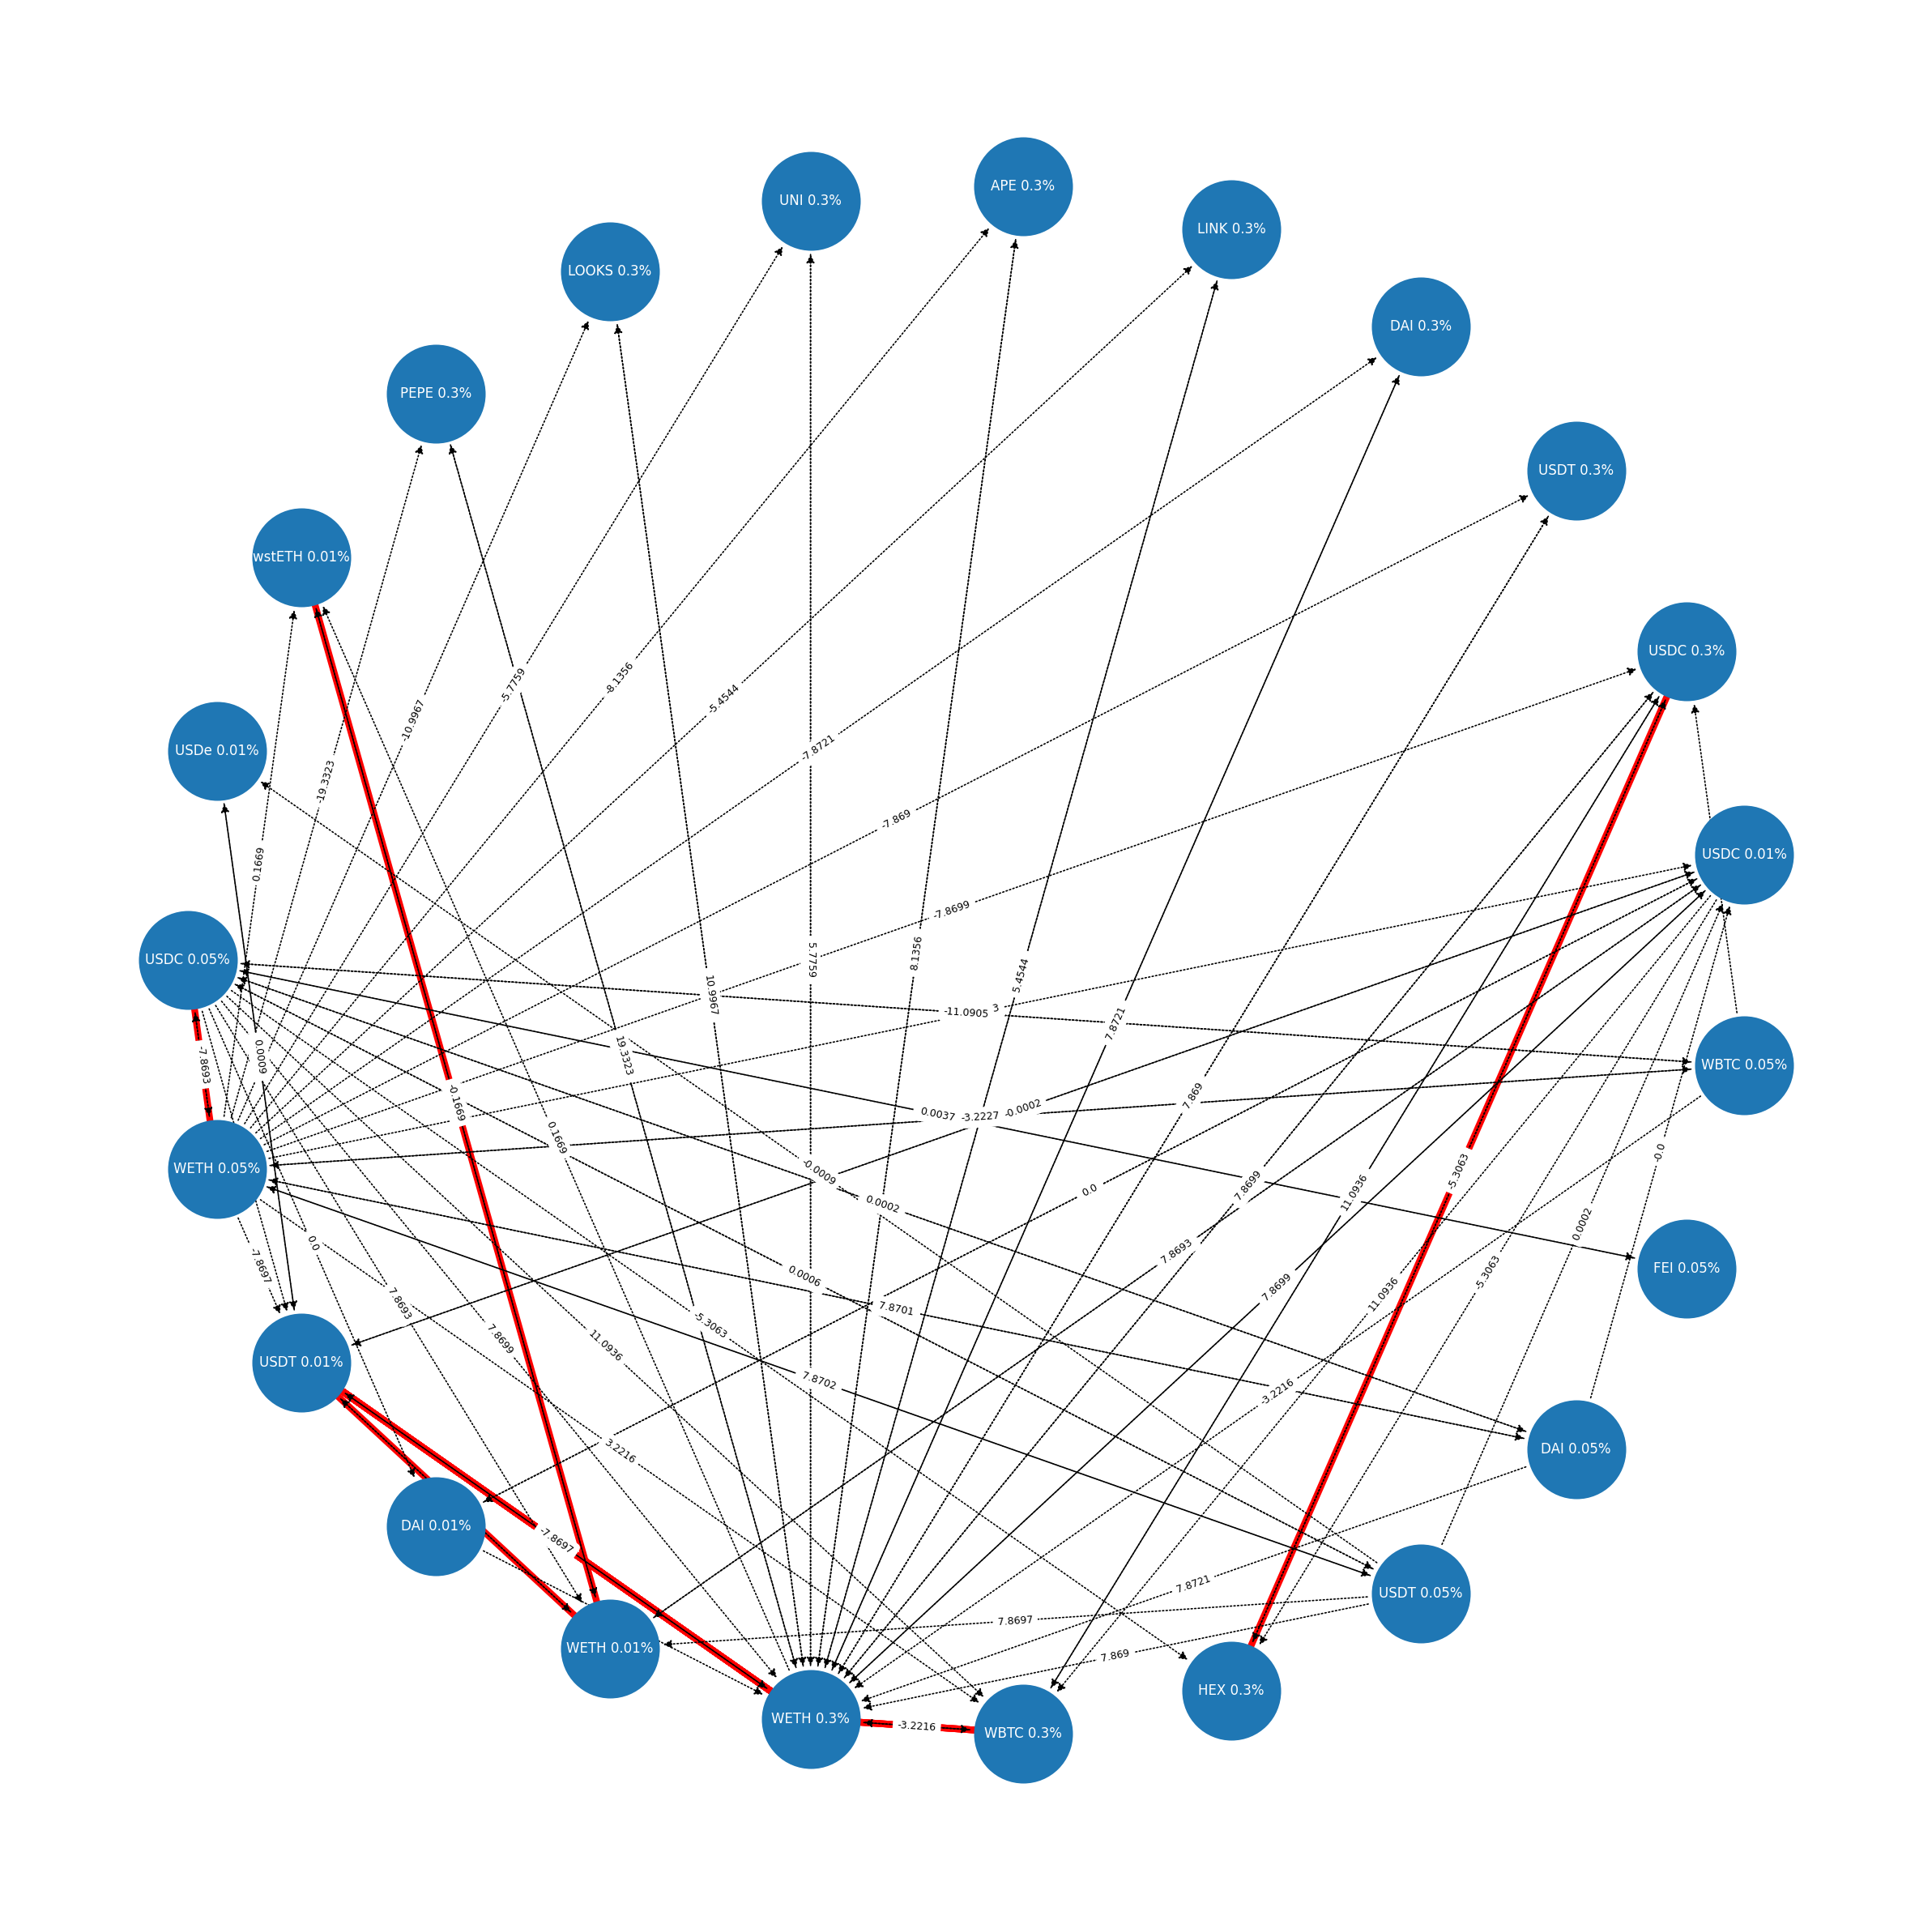

In [10]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.MultiDiGraph()
G.add_weighted_edges_from(E)
plt.figure(3, figsize=(10, 10), dpi=300)

pos = nx.shell_layout(G) 
# C = nx.Graph([('WETH-500', 'USDT-500'), ('USDT-500','USDC-500')])

all_cycles = []

def draw_cycles(vertices):
  for vertex in vertices:
    try:
      cycle = nx.find_negative_cycle(G, vertex)
      cycle_found = []
      left = 0
      for right in range(1, len(cycle)):
        cycle_found.append((cycle[left], cycle[right]))
        left += 1
      
      all_cycles.append(cycle)
      # print(f"Cycle found {cycle_found}")
      # print(f"cycle", cycle)
      for pairs in cycle_found:
        token0 = pairs[0]
        token1 = pairs[1]

        search0 = token0.split(' ')
        origin, fee0 = search0
        fee0 = str(round(float(fee0[:-1]) * 10000))

        search1 = token1.split(' ')
        dest, fee1 = search1
        fee1 = str(round(float(fee1[:-1]) * 10000))
        search_for_pool(origin, dest, fee0)
        break

      C = nx.Graph(cycle_found)
      nx.draw_networkx_edges(C, pos, edge_color="red", width=2)
    except:
      continue

draw_cycles(V)

nx.draw_networkx_nodes(G, pos, node_color="tab:blue", node_size=800)
nx.draw_networkx_edges(G, pos, edge_color="black", width=.4, connectionstyle="arc3", min_source_margin=5, min_target_margin=5, style='dotted', arrowsize=5, node_size=1000)
nx.draw_networkx_labels(G, pos, font_size=4, font_family="sans-serif", font_color="white",)
nx.draw_networkx_edge_labels(G,pos, font_size=3, edge_labels={(u, v): d['weight'] for u, v, d in G.edges(data=True)})

def search_for_pool(origin, dest, feeTier):
  pools = data['data']['pools']
  for pool in pools:
    fee = pool['feeTier']
    if fee == feeTier:
      token1 = pool['token1']['symbol']
      token0 = pool['token0']['symbol']
      if (token1 == origin and token0 == dest) or (token0 == origin and token1 == dest):
        # print(pool)
        pass

plt.axis("off")
plt.show()

### 2.4 Analyze arbirage opportunities and from negative cycles path

In [6]:
opportunities = []
def collect_paths(cycles):
  # path = ['WBTC 0.3%', 'WETH 0.3%', 'USDC 0.3%', 'WBTC 0.3%']
  for path in cycles:
    left = 0
    total = 0
    route = ""
    # print(path)
    for right in range(1, len(path)):
      weight = G.get_edge_data(path[left], path[right])[0]['weight']
      route += f"({path[left]}, {path[right]}) -> "
      total += weight
      left += 1
      # print(weight)
    opportunities.append((route ,total))



collect_paths(all_cycles)
print(f"No. of arbitrage routes {len(opportunities)}")

def arbitrage_for_range(lower, upper):
  sweet_opportunities = []
  for chance in opportunities:
    if lower > chance[1] > upper:
      sweet_opportunities.append(chance) 
      print(chance)
  return sweet_opportunities


lower = -0.001
upper = -0.09
# print(f"No. of arbitrage between {-lower * 100}% - {-upper * 100}% return {len(arbitrage_for_range(lower, upper))}")
lower = -0.01
upper = -0.09
print(f"No. of arbitrage between {-lower * 100}% - {-upper * 100}% return {len(arbitrage_for_range(lower, upper))}")

No. of arbitrage routes 23
No. of arbitrage between 1.0% - 9.0% return 0


### 2.5.1 Search for desired pools

In [7]:
def search_for_pool(pool):
  search = pool
  pools = data['data']['pools']
  for pool in pools:
    if pool['token1']['symbol'] == search or pool['token0']['symbol'] == search:
      print(pool)

search_for_pool("UNI")

{'feeTier': '3000', 'id': '0x1d42064fc4beb5f8aaf85f4617ae8b3b5b8bd801', 'token0': {'decimals': '18', 'id': '0x1f9840a85d5af5bf1d1762f925bdaddc4201f984', 'name': 'Uniswap', 'symbol': 'UNI'}, 'token0Price': '322.4478663591623709957881024198276', 'token1': {'decimals': '18', 'id': '0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2', 'name': 'Wrapped Ether', 'symbol': 'WETH'}, 'token1Price': '0.003101276529726322234273693051326451'}


### 2.5.2 Read pool data from all available node graph

In [8]:
# print(N['WETH']['3000']['WBTC'])
# print(N['WBTC']['3000']['WETH'])
# print(N['WETH']['10000']['WBTC'])
# print(N['WBTC']['10000']['WETH'])